In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(viridis))
suppressMessages(library(igraph))
suppressMessages(library(ggraph))
suppressMessages(library(tidygraph))
suppressMessages(library(patchwork))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))

In [2]:
coembed <- readRDS("../../../IntegrativeAnalysis/Endothelial/data/coembed/coembed.annotation.Rds")

In [3]:
df_count <- coembed@meta.data %>%
    as.data.frame() %>%
    group_by(annotation, tech) %>%
    summarise(count = n())

df_count

write.csv(df_count, "df_count.csv")

`summarise()` has grouped output by 'annotation'. You can override using the
`.groups` argument.


annotation,tech,count
<fct>,<chr>,<int>
Capillary_Endo,ATAC,2652
Capillary_Endo,RNA,10378
Venous_Endo,ATAC,960
Venous_Endo,RNA,5473
Arterial_Endo,ATAC,954
Arterial_Endo,RNA,4886
Endocardial_Endo,ATAC,297
Endocardial_Endo,RNA,2294
Lymphatic_Endo,ATAC,74


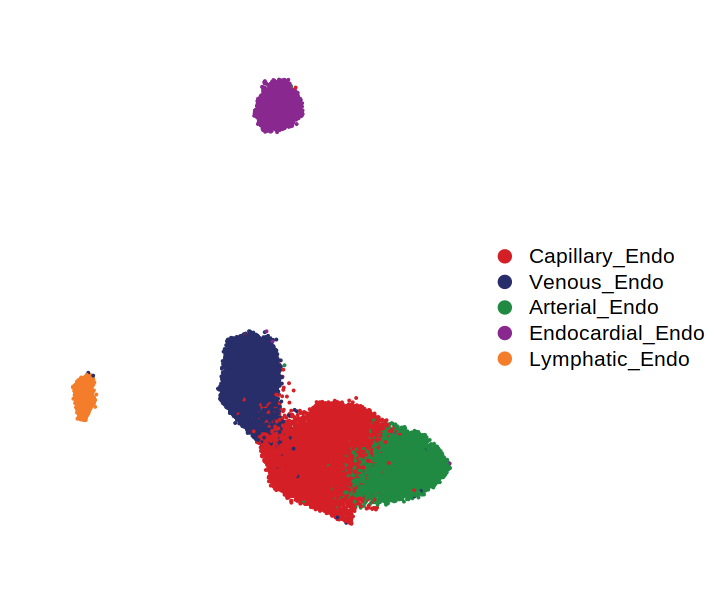

In [3]:
options(repr.plot.height = 5, repr.plot.width = 6)

cols <- ArchR::paletteDiscrete(unique(coembed$annotation))

p1 <- DimPlot(coembed, reduction = "umap_harmony_v2", group.by = "annotation",
             cols = cols) +
    xlab("") + ylab("") + ggtitle("") +
    theme(axis.ticks = element_blank(),
         axis.text = element_blank(),
         axis.line = element_blank())
p1

ggsave("endothelial_sub_clustering.pdf", plot=p1, height = 5, width = 6)

In [4]:
cols

Capillary_Endo      Venous_Endo    Arterial_Endo Endocardial_Endo 
       "#D51F26"        "#272E6A"        "#208A42"        "#89288F" 
  Lymphatic_Endo 
       "#F47D2B"

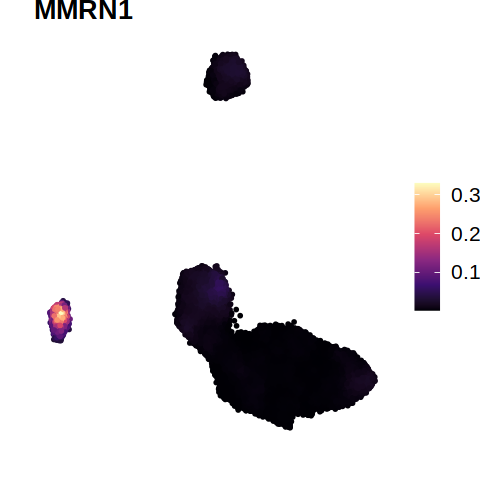

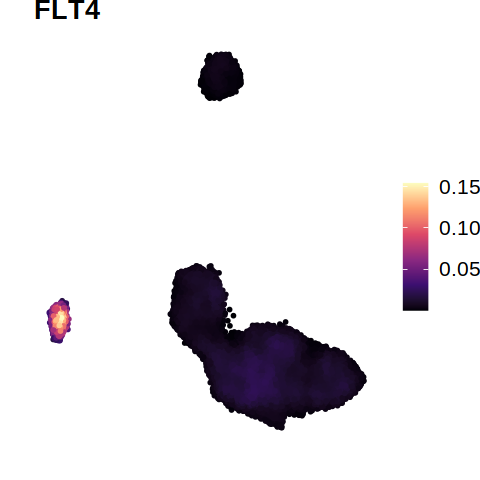

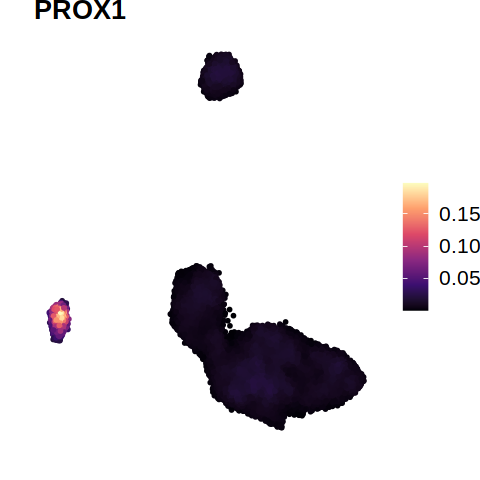

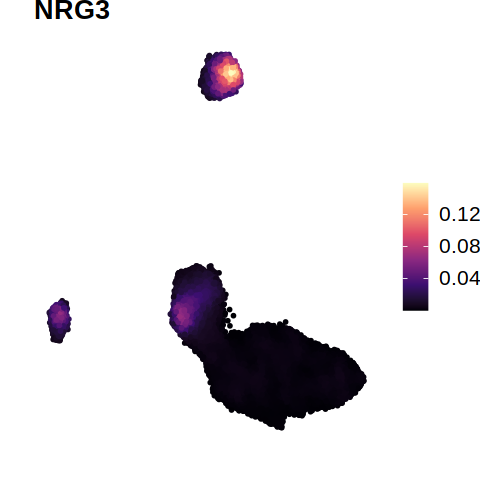

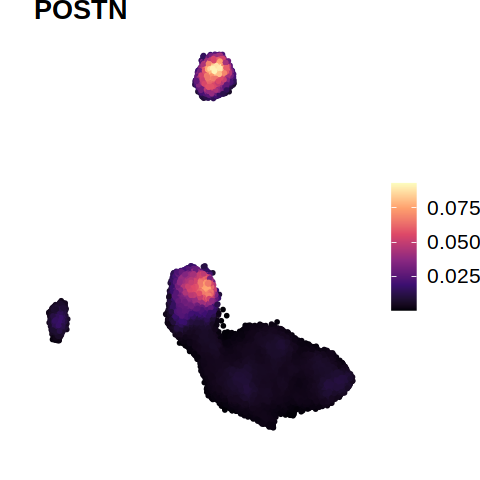

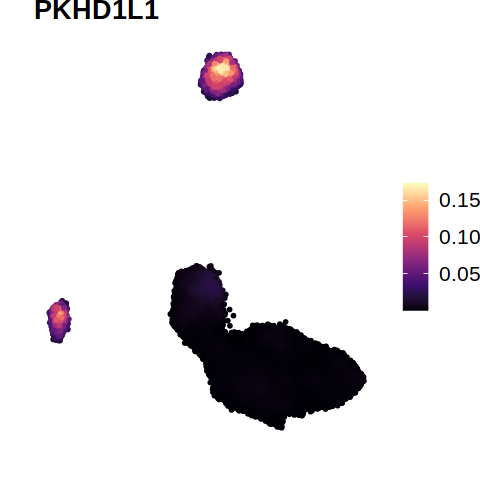

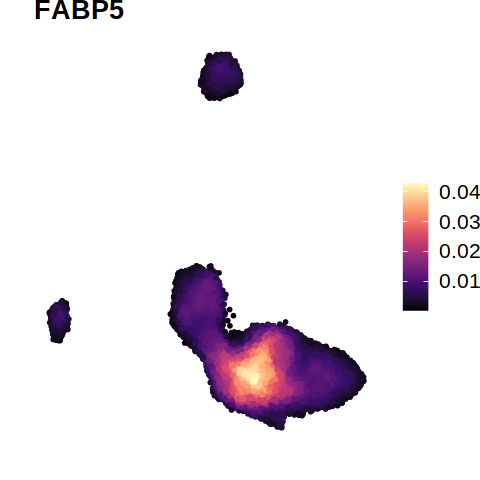

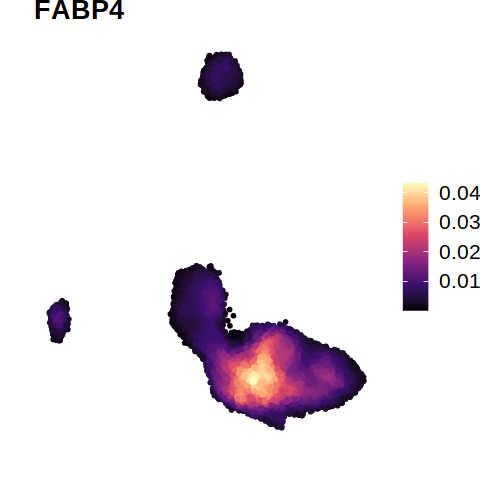

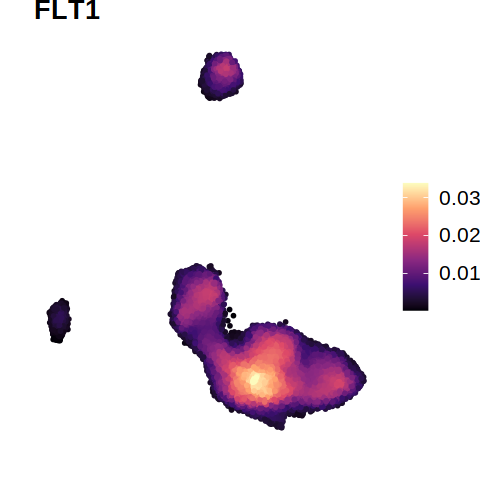

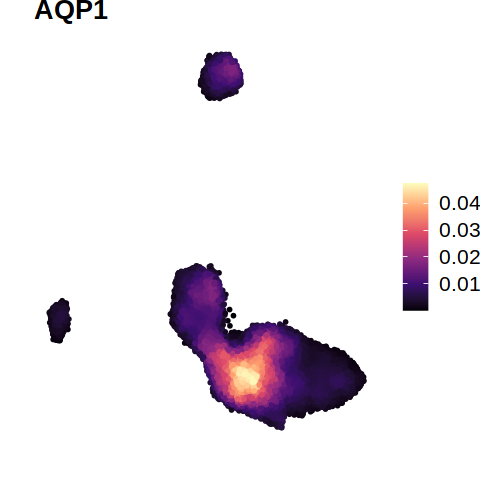

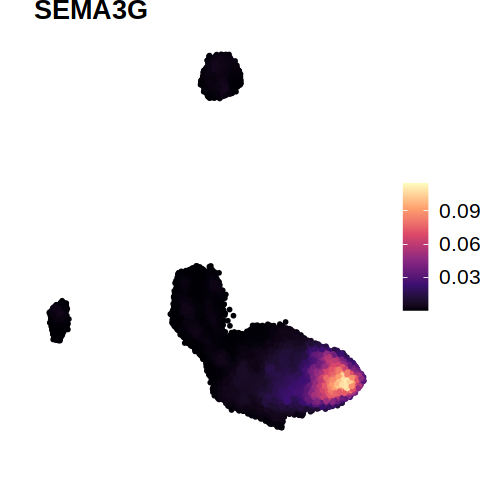

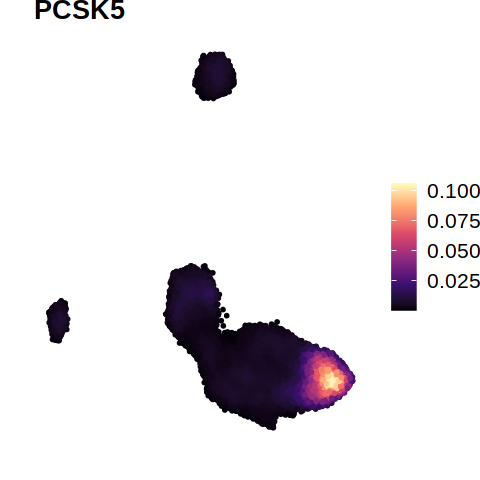

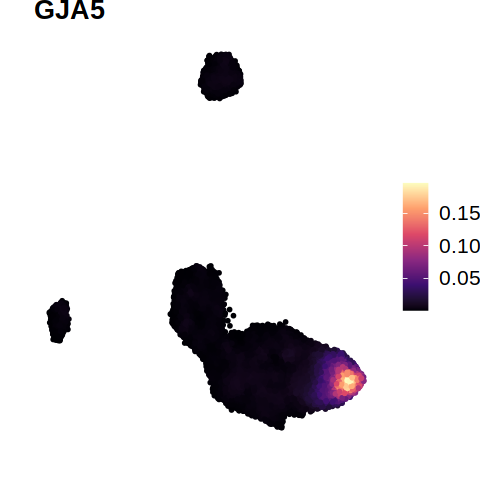

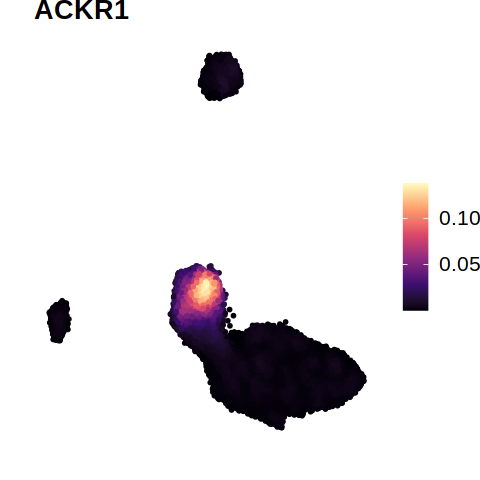

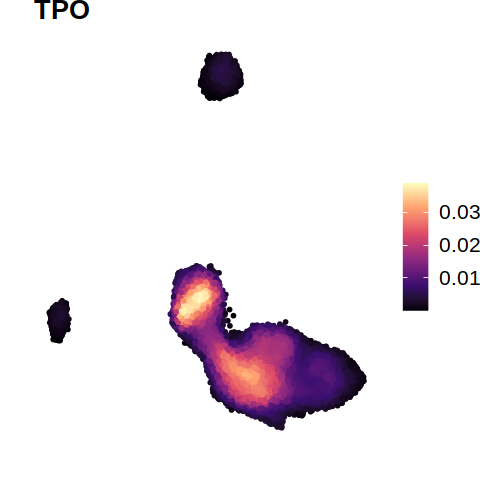

[[1]]
marker_MMRN1.pdf

[[2]]
marker_FLT4.pdf

[[3]]
marker_PROX1.pdf

[[4]]
marker_NRG3.pdf

[[5]]
marker_POSTN.pdf

[[6]]
marker_PKHD1L1.pdf

[[7]]
marker_FABP5.pdf

[[8]]
marker_FABP4.pdf

[[9]]
marker_FLT1.pdf

[[10]]
marker_AQP1.pdf

[[11]]
marker_SEMA3G.pdf

[[12]]
marker_PCSK5.pdf

[[13]]
marker_GJA5.pdf

[[14]]
marker_ACKR1.pdf

[[15]]
marker_TPO.pdf

[[16]]
marker_FAM155A.pdf

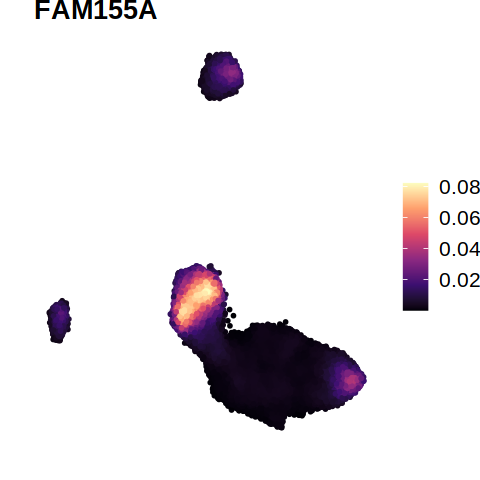

In [5]:
## plot markers
options(repr.plot.width = 4, repr.plot.height = 4)

gene.list <- c("MMRN1", "FLT4", "PROX1",
              "NRG3", "POSTN", "PKHD1L1",
              "FABP5", "FABP4", "FLT1", "AQP1",
              "SEMA3G", "PCSK5", "GJA5",
              "ACKR1", "TPO", "FAM155A")

lapply(gene.list, function(gene){
    p <- plot_density(coembed, features = gene, reduction = "umap_harmony_v2",
                     pal = "magma") +
        xlab("") + ylab("") + ggtitle(gene) +
    theme_cowplot() +
    theme(axis.line = element_blank(),
         axis.ticks = element_blank(),
         axis.text = element_blank(),
         legend.title = element_blank(),
         plot.margin = unit(c(0, 0, 0, 0), "cm"))
    
    print(p)
    
    ggsave(glue::glue("marker_{gene}.pdf"), plot = p, height = 4, width = 4)
    
})


`summarise()` has grouped output by 'patient_region_id'. You can override using
the `.groups` argument.


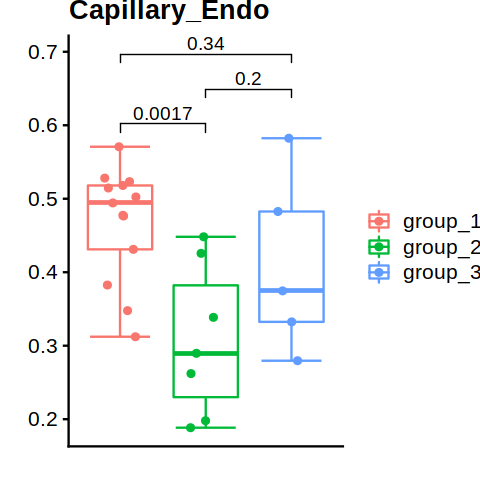

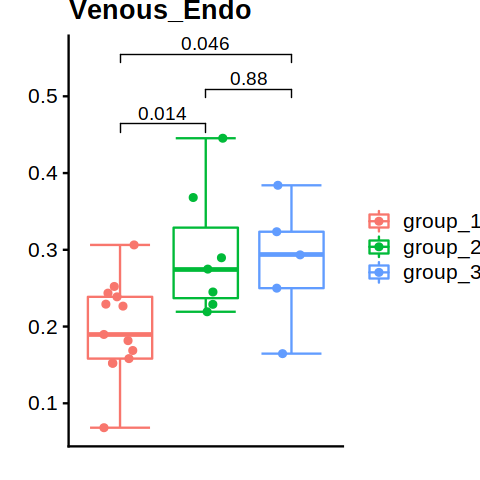

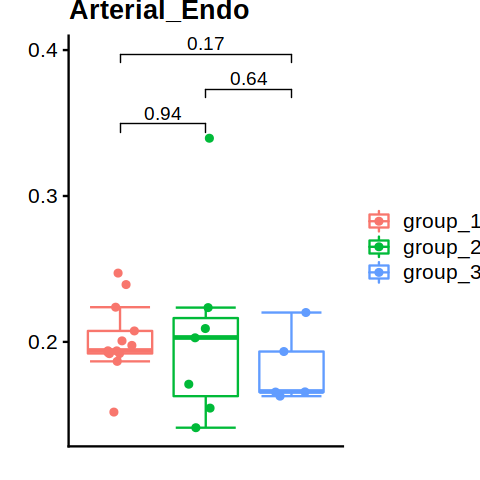

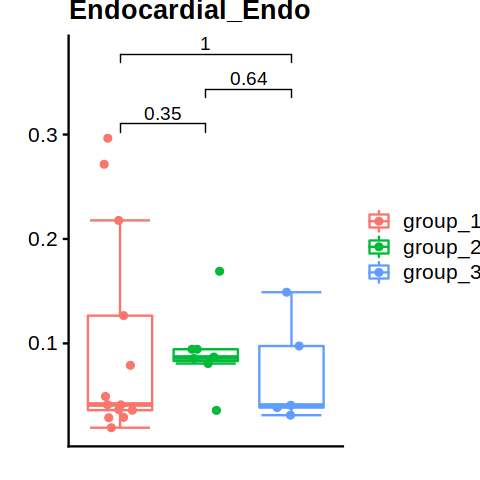

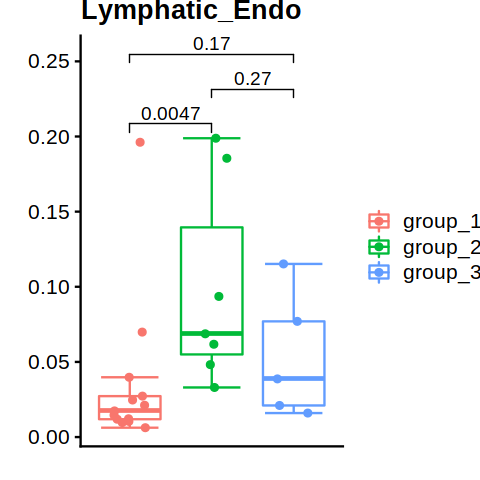

In [6]:
## we here update the annotaiton of samples
meta.data <- as.data.frame(coembed@meta.data) %>%
    rename(sample_id = orig.ident) %>%
    select(c(sample_id, annotation))

df_atac_anno <- read.csv("../../../Annotations_figures/atac_patient_anns_revisions.csv")
df_rna_anno <- read.csv("../../../Annotations_figures/rna_patient_anns_revisions.csv")

df_anno <- rbind(df_atac_anno, df_rna_anno) %>%
    select(c(sample_id, patient, patient_region_id, patient_group)) %>%
    subset(sample_id %in% meta.data$sample_id)

meta.data <- meta.data %>%
    dplyr::full_join(df_anno, by = "sample_id")

df_plot <- meta.data %>%
    group_by(patient_region_id, annotation) %>%
    summarise(counts = n()) %>%
    mutate(proportion = counts / sum(counts))

df_anno <- meta.data %>%
    subset(., select = c("patient_region_id", "patient_group")) %>%
    unique()

df_plot <- merge.data.frame(df_plot, df_anno)

options(repr.plot.width = 4, repr.plot.height = 4)

for(anno in unique(df_plot$annotation)){
    p <- df_plot %>%
        subset(annotation == anno) %>%
        ggplot(aes(x = patient_group, y = proportion)) +
        geom_boxplot2(aes(color = patient_group)) +
        geom_point(aes(color = patient_group), position = position_jitterdodge(), size = 1.5) +
        stat_compare_means(comparisons = list(c("group_1", "group_2"),
                                             c("group_2", "group_3"),
                                             c("group_1", "group_3")),
                       method = "wilcox.test"
                          #label.y = c(0.6, 0.65, 0.7),
                          ) +
        ggtitle(anno) +
        theme_cowplot() +
        #ylim(0, 0.75) +
        xlab("") + ylab("") +
        theme(axis.text.x = element_blank(),
             legend.title = element_blank(),
             axis.ticks.x = element_blank(),
             plot.margin = unit(c(0, 0, 0, 0), "cm")
             )
    
    print(p)
    
    ggsave(glue::glue("{anno}_with_p_value.pdf"), plot = p, height = 4, width = 4)

}

In [7]:
# meta.data <- as.data.frame(coembed@meta.data)

# df_plot <- meta.data %>% 
#             group_by(patient_region_id, annotation) %>%
#             summarise(counts = n()) %>%
#             mutate(proportion = counts / sum(counts))

# df_anno <- meta.data %>%
#     subset(., select = c("patient_region_id", "patient_group")) %>%
#     unique()

# df_plot <- merge.data.frame(df_plot, df_anno) %>%
#     subset(annotation %in% c("Capillary_Endo", "Venous_Endo", "Lymphatic_Endo"))

# options(repr.plot.width = 4, repr.plot.height = 4)

# for(anno in unique(df_plot$annotation)){
#     p <- df_plot %>%
#         subset(annotation == anno) %>%
#         ggplot(aes(x = patient_group, y = proportion)) +
#         geom_boxplot2(aes(color = patient_group)) +
#         geom_point(aes(color = patient_group), position = position_jitterdodge(), size = 1.5) +
#         stat_compare_means(comparisons = list(c("group_1", "group_2"),
#                                              c("group_2", "group_3"),
#                                              c("group_1", "group_3")),
#                        method = "wilcox.test",
#                           label.y = c(0.6, 0.65, 0.7)) +
#         ggtitle(anno) +
#         theme_cowplot() +
#         ylim(0, 0.75) +
#         xlab("") + ylab("") +
#         theme(axis.text.x = element_blank(),
#              legend.title = element_blank(),
#              axis.ticks.x = element_blank(),
#              plot.margin = unit(c(0, 0, 0, 0), "cm")
#              )
    
#     print(p)
    
#     ggsave(glue::glue("{anno}_with_p_value.pdf"), plot = p, height = 4, width = 4)

# }

In [8]:
# ## load TF activity
# df_tf <- read.csv("../../../snATAC/HINT_Endothelial_V2/DiffFootprints/Heatmap/tf_activity.csv",
#                  row.names = 1)
# rownames(df_tf) <- stringr::str_split_fixed(rownames(df_tf), "\\.", 3)[, 3]

# avg_exp <- AverageExpression(coembed, assays = "RNA", group.by = "annotation")$RNA
# avg_exp <- avg_exp[, colnames(df_tf)]

# avg_exp_scale <- as.data.frame(t(scale(t(avg_exp))))
# avg_exp_scale <- tidyr::drop_na(avg_exp_scale)

# sel_tf <- intersect(rownames(avg_exp_scale), rownames(df_tf))

# df_tf <- df_tf[sel_tf, ]
# avg_exp_scale <- avg_exp_scale[sel_tf, colnames(df_tf)]

# ## compute correlation
# df_cor <- cor(t(avg_exp_scale), t(df_tf), method = "pearson") %>%
#     diag() %>%
#     as.data.frame()

# colnames(df_cor) <- "correlation"
# df_cor$tf <- rownames(df_cor)

# df_cor <- subset(df_cor, correlation > 0.5)

# df_tf <- df_tf[df_cor$tf, ]
# avg_exp_scale <- avg_exp_scale[df_cor$tf, ]

# ht1 <- Heatmap(as.matrix(df_tf),
#                name = "TF activity",
#                              rect_gp = gpar(col = "black", lwd = 0.5),
#              col = ArchR::paletteContinuous("blueYellow", n = 100),
#                show_column_dend = FALSE,
#              clustering_method_rows = "ward.D2",
#               clustering_method_columns = "ward.D2"
#               )

# ht2 <- Heatmap(as.matrix(avg_exp_scale),
#                name = "TF expression",
#               row_order = row_order(ht1),
#               column_order = column_order(ht1),
#             rect_gp = gpar(col = "black", lwd = 0.5),
#              col = ArchR::paletteContinuous("solarExtra", n = 100))

# options(repr.plot.height = 12, repr.plot.width = 5)

# ht1 + ht2

# pdf("tf_activity_expression_heatmap.pdf", height = 12, width = 5)
# draw(ht1 + ht2)
# dev.off()

In [9]:
# ht1 <- Heatmap(as.matrix(df_tf),
#                name = "TF activity",
#                              rect_gp = gpar(col = "black", lwd = 0.5),
#              col = ArchR::paletteContinuous("blueYellow", n = 100),
#                show_column_dend = FALSE,
#              clustering_method_rows = "ward.D2",
#               clustering_method_columns = "ward.D2",
#                show_row_names = FALSE
#               )

# ht2 <- Heatmap(as.matrix(avg_exp_scale),
#                name = "TF expression",
#               row_order = row_order(ht1),
#               column_order = column_order(ht1),
#             rect_gp = gpar(col = "black", lwd = 0.5),
#              col = ArchR::paletteContinuous("solarExtra", n = 100),
#               show_row_names = FALSE
#               )

# options(repr.plot.height = 5, repr.plot.width = 3)

# ht1 + ht2

# pdf("tf_activity_expression_heatmap_without_name.pdf", height = 5, width = 3)
# draw(ht1 + ht2)
# dev.off()

In [10]:
# cols

In [11]:
# ## plot TF
# input_dir <- "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/snATAC/HINT_Endothelial_V2/DiffFootprints/Diff/Lineplots"

# ## KLF4
# df <- read.table(glue::glue("{input_dir}/MA0039.4.KLF4.txt"),
#                  header = TRUE)
# cols <- c("Capillary_Endo" = "#D51F26",
#          "Venous_Endo" = "#272E6A",
#          "Arterial_Endo" = "#208A42",
#          "Endocardial_Endo" = "#89288F")

# df$Pos <- seq(from = -99, to = 100)

# df <- melt(df, id.var = c("Pos"))
# p <- ggplot(data = df, aes(x = Pos, y = value, color = variable)) +
#     geom_line(size=1) + xlab("") + ylab("") +
#     scale_colour_manual(values = cols) + 
#     theme_cowplot()  + 
#     theme(legend.title = element_blank(),
#         plot.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "pt"))


# options(repr.plot.height = 3, repr.plot.width = 6)

# p

# ggsave("KLF4.pdf", p, height = 3, width = 6)

In [12]:
# ## KLF4
# df <- read.table(glue::glue("{input_dir}/MA0766.2.GATA5.txt"),
#                  header = TRUE)
# df$Pos <- seq(from = -99, to = 100)

# df <- melt(df, id.var = c("Pos"))
# p <- ggplot(data = df, aes(x = Pos, y = value, color = variable)) +
#     geom_line(size=1) + xlab("") + ylab("") +
#     scale_colour_manual(values = cols) + 
#     theme_cowplot()  + 
#     theme(legend.title = element_blank(),
#         plot.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "pt"))


# options(repr.plot.height = 3, repr.plot.width = 6)

# p

# ggsave("GATA5.pdf", p, height = 3, width = 6)

In [13]:
## Misty results
df <- read.csv("./endo_misty/summarized_importances.csv")

df1 <- subset(df, view == "intra_pred") %>%
    select(-view) %>%
    select(Target, Predictor, median_imp) %>%
    tidyr::pivot_wider(names_from = Target, values_from = median_imp) %>%
    textshape::column_to_rownames('Predictor')

df2 <- subset(df, view == "para_pred_5") %>%
    select(-view) %>%
    select(Target, Predictor, median_imp) %>%
    tidyr::pivot_wider(names_from = Target, values_from = median_imp) %>%
    textshape::column_to_rownames('Predictor')

col_fun <- colorRamp2(seq(from = 0, to = 2.5, length = 9), 
                     RColorBrewer::brewer.pal(name = "BuGn", n = 9))

colnames(df1) <- c("Arterial_Endo", 
                  "Capillary_Endo",
                  "Endocardial_Endo",
                  "Lymphatic_Endo",
                  "Venous_Endo")

colnames(df2) <- c("Arterial_Endo", 
                  "Capillary_Endo",
                  "Endocardial_Endo",
                  "Lymphatic_Endo",
                  "Venous_Endo")

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”
Warning message:
“Heatmap/annotation names are duplicated: Importance”
Warning message:
“Heatmap/annotation names are duplicated: Importance”


png 
  2

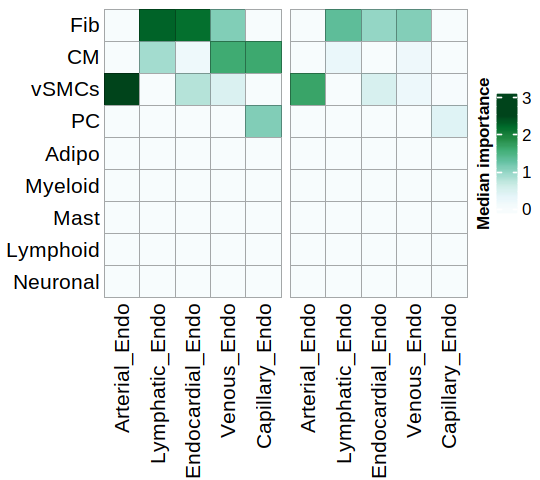

In [15]:
ht1 <- Heatmap(as.matrix(df1), 
               name = "Importance",
               cluster_columns = TRUE,
              cluster_rows = TRUE,
               show_row_dend = FALSE,
               show_column_dend = FALSE,
            clustering_method_rows = "ward.D2",
              clustering_method_columns = "ward.D2",
               rect_gp = gpar(col = "black", lwd = 0.2),
               heatmap_legend_param = list(
                title = "Median importance",
               title_position = "leftcenter-rot",
               legend_height = unit(2.5, "cm")),
              col = col_fun,
              na_col = "white",
             row_names_side = "left"
              )

ht2 <- Heatmap(as.matrix(df2), 
               name = "Importance",
               row_order = row_order(ht1),
               column_order = column_order(ht1),
               rect_gp = gpar(col = "black", lwd = 0.2),
               heatmap_legend_param = list(
                title = "Median importance",
               title_position = "leftcenter-rot",
               legend_height = unit(2.5, "cm")),
              col = col_fun,
              na_col = "white",
             row_names_side = "left"
              )

options(repr.plot.height = 4, repr.plot.width = 4.5)

ht1 + ht2

pdf("misty_heatmap.pdf", height = 4, width = 4.5)
draw(ht1+ht2)
dev.off()